## Inference with the best simple task solvers as a baseline for SoilNet

In [1]:
import os
os.chdir('../../../')
!pwd

/storage/projects/BGR Soil


In [2]:
import pickle
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_  # modifies the tensors in-place (vs clip_grad_norm)
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
import sys
sys.path.append('./BGR')
from bgr.soil.data.datasets import ImageTabularDataset
from bgr.soil.data.horizon_tabular_data import HorizonDataProcessor
import bgr.soil.modelling.depth.depth_models as bgr_mod
from bgr.soil.callbacks import EarlyStopping, ModelCheckpoint
from bgr.soil.transforms import VerticalStripeCrop
from bgr.soil.metrics import DepthMarkerLoss, TopKHorizonAccuracy, DepthIoULoss, depth_iou, precision_recall_at_k, top_k_accuracy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from bgr.soil.utils import pad_tensor

from sklearn.metrics import confusion_matrix
import re

def plot_confusion_matrices(labels, predictions, emb_dict, output_dir, mode='test'):
    """
    Plots two confusion matrices - one for all the terminal symbols, one for the (aggregated) main symbols - as heatmaps and saves/logs them.
    
    Args:
        labels (list or array): True labels.
        predictions (list or array): Predicted labels.
        emb_dict (dict): Dictionary with label mappings.
        output_dir (str): Directory to save the confusion matrix image.
        wandb_image_logging (bool): Whether to log the image to Weights & Biases.
        mode (str): Mode of the confusion matrix (e.g., 'test', 'train').
        cmap (str): Colormap for the heatmap.
        annotate (bool): Whether to annotate the heatmap with cell values.
    """
    def sort_by_last_capital(label):
        # Find all capital letters in the string
        capitals = re.findall(r'[A-Z]', label)
        # Use the last capital letter if it exists, otherwise fallback to the first character
        return capitals[-1] if capitals else label[0]
    
    def plot_and_save_cm(labels, predictions, possible_labels, agg_level='terminal'):
        # Calculate accuracy score based on the current level's labels/predictions
        accuracy = accuracy_score(labels, predictions)
        
        # Compute confusion matrix
        cm = confusion_matrix(labels, predictions, labels=possible_labels, normalize='true')
        
        # Set up the figure size dynamically for large matrices
        fig_size = max(10, len(possible_labels) * 0.2)
        
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))
        sns.heatmap(cm, cmap='Blues',
                    xticklabels=possible_labels, yticklabels=possible_labels, 
                    cbar_kws={'shrink': 0.8}, linewidths=0.5, linecolor='lightgray')
        ax.set_aspect('equal')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(f'Confusion Matrix {mode} - Accuracy: {accuracy:.4f}', fontsize=14)
        
        # Save the figure
        os.makedirs(output_dir, exist_ok=True)
        cm_path = os.path.join(output_dir, f'confusion_matrix_{mode}_{agg_level}.pdf')
        plt.savefig(cm_path, bbox_inches='tight', format='pdf')
        
        return fig

    ### Matrix for all terminal symbols
    labels = [emb_dict['ind2label'][label] for label in labels]
    predictions = [emb_dict['ind2label'][label] for label in predictions]
    possible_labels = sorted(emb_dict['ind2label'], key=sort_by_last_capital)
    fig1 = plot_and_save_cm(labels, predictions, possible_labels)
    
    ### Matrix for main symbols
    # Aggregate into main symbols (keep the last capital letter in case of mixtures)
    labels = [re.findall(r'[A-Z]', label)[-1] for label in labels]
    predictions = [re.findall(r'[A-Z]', label)[-1] for label in predictions]
    possible_labels = sorted(set(labels))
    fig2 = plot_and_save_cm(labels, predictions, possible_labels, agg_level='main')
    
    return fig1, fig2

### Data Loading

In [4]:
dataprocessor = HorizonDataProcessor(label_embeddings_path='./BGR/label_embeddings/all_horizons_embeddings_thirds.pickle')
df = dataprocessor.load_processed_data()

train_df, val_df, test_df = dataprocessor.multi_label_stratified_shuffle_split(df, train_val_test_frac=[0.6, 0.2, 0.2], random_state=2025)

In [5]:
from bgr.soil.data.datasets import ImageTabularEnd2EndDataset
import torchvision.transforms as transforms

test_dataset = ImageTabularEnd2EndDataset(
    dataframe=test_df,
    normalize=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
        ]),
    label_column='Horizontsymbol_relevant',
    geotemp_columns=dataprocessor.geotemp_img_infos[:-1], # without img path
    tab_num_columns=['Steine'],
    tab_categ_columns={key : value 
            for key, value in dataprocessor.tabulars_output_dim_dict.items() 
                if key in [
                        'Bodenart',
                        'Bodenfarbe',
                        'Karbonat',
                        'Humusgehaltsklasse',
                        'Durchwurzelung'
                    ]
        }
)

test_loader = test_dataset.to_dataloader(batch_size=8, shuffle=True, num_workers=16, drop_last=True)


### Load individual Task Solvers

In [6]:
# Task model paths
depth_predictor_path = './model_output/simple_depths_maskedresnet_lstm_2025-05-12_14-44-21/model.pt'
tabular_predictor_path = './model_output/simple_tabulars_geotmp_resnet_2025-05-08_13-39-13/model.pt'
horizon_resnet_ce_path = './model_output/simple_horizon_classification_lstm_geotmp_mlp_tab_mlp_resnet_2025-05-12_15-30-38/model.pt'
horizon_resnet_emb_path = './model_output/simple_horizon_classification_lstm_embed_geotmp_mlp_tab_mlp_resnet_2025-05-12_17-00-46/model.pt'

# Note: The segment encoder (ResNet or PatchCNN) of the tabular predictor must match the one from the horizon predicotr
horizon_cnn_ce_path = './model_output/simple_horizon_classification_lstm_geotmp_mlp_tab_mlp_2025-05-12_16-35-58/model.pt'
horizon_cnn_emb_path = './model_output/simple_horizon_classification_lstm_embed_geotmp_mlp_tab_mlp_2025-05-12_18-45-21/model.pt'

#### Depth Predictor

In [7]:
from bgr.soil.modelling.depth.depth_models import SimpleDepthModelMaskedResNetLSTM
depth_predictor = SimpleDepthModelMaskedResNetLSTM(
            geo_temp_input_dim=len(dataprocessor.geotemp_img_infos) - 2, # without index and img path
            geo_temp_output_dim=256,
            image_encoder_output_dim=512,
            max_seq_len=8,
            stop_token=1.0,
            rnn_hidden_dim=256
        )
depth_predictor.load_state_dict(torch.load(depth_predictor_path))

<All keys matched successfully>

#### Tabular Predictor

In [8]:
from bgr.soil.modelling.tabulars.tabular_models import SimpleTabularModel
tabular_predictor = SimpleTabularModel(
            tabular_output_dim_dict=dataprocessor.tabulars_output_dim_dict,
            geotemp_input_dim=len(dataprocessor.geotemp_img_infos) - 2, # without index and img path
            segment_encoder_output_dim=512,
            geotemp_output_dim=256,
            rnn_hidden_dim=1024,
            num_lstm_layers=2,
            predefined_random_patches=True
        )
tabular_predictor.load_state_dict(torch.load(tabular_predictor_path))

<All keys matched successfully>

#### Horizon Predictor

In [9]:
# Same classes used with cosine and cross entropy loss, with custom CNN and ResNet segment encoders
from bgr.soil.modelling.horizon.horizon_models import SimpleHorizonClassifierWithEmbeddingsGeotempsMLPTabMLP

segments_tabular_categ_feature_columns = {key : value 
    for key, value in dataprocessor.tabulars_output_dim_dict.items() 
        if key in [
                'Bodenart',
                'Bodenfarbe',
                'Karbonat',
                'Humusgehaltsklasse',
                'Durchwurzelung'
            ]
} 

In [10]:
horizon_cnn_ce_predictor = SimpleHorizonClassifierWithEmbeddingsGeotempsMLPTabMLP(
            geo_temp_input_dim=len(dataprocessor.geotemp_img_infos) - 2, # without index and img path
            segments_tabular_input_dim=len(['Steine']) + sum(segments_tabular_categ_feature_columns.values()),
            segment_encoder_output_dim=512,
            segments_tabular_output_dim=256,
            geo_temp_output_dim=256,
            embedding_dim=len(dataprocessor.embeddings_dict['embedding']),
            embed_horizons_linearly=False
        )
horizon_cnn_ce_predictor.load_state_dict(torch.load(horizon_cnn_ce_path))

<All keys matched successfully>

In [11]:
horizon_cnn_emb_predictor = SimpleHorizonClassifierWithEmbeddingsGeotempsMLPTabMLP(
            geo_temp_input_dim=len(dataprocessor.geotemp_img_infos) - 2, # without index and img path
            segments_tabular_input_dim=len(['Steine']) + sum(segments_tabular_categ_feature_columns.values()),
            segment_encoder_output_dim=512,
            segments_tabular_output_dim=256,
            geo_temp_output_dim=256,
            embedding_dim=np.shape(dataprocessor.embeddings_dict['embedding'])[1],
            embed_horizons_linearly=False
        )
horizon_cnn_emb_predictor.load_state_dict(torch.load(horizon_cnn_emb_path))

<All keys matched successfully>

In [12]:
horizon_resnet_ce_predictor = SimpleHorizonClassifierWithEmbeddingsGeotempsMLPTabMLP(
            geo_temp_input_dim=len(dataprocessor.geotemp_img_infos) - 2, # without index and img path
            segments_tabular_input_dim=len(['Steine']) + sum(segments_tabular_categ_feature_columns.values()),
            segment_encoder_output_dim=512,
            segments_tabular_output_dim=256,
            geo_temp_output_dim=256,
            embedding_dim=len(dataprocessor.embeddings_dict['embedding']),
            embed_horizons_linearly=False,
            predefined_random_patches=True
        )
horizon_resnet_ce_predictor.load_state_dict(torch.load(horizon_resnet_ce_path))

<All keys matched successfully>

In [13]:
horizon_resnet_emb_predictor = SimpleHorizonClassifierWithEmbeddingsGeotempsMLPTabMLP(
            geo_temp_input_dim=len(dataprocessor.geotemp_img_infos) - 2, # without index and img path
            segments_tabular_input_dim=len(['Steine']) + sum(segments_tabular_categ_feature_columns.values()),
            segment_encoder_output_dim=512,
            segments_tabular_output_dim=256,
            geo_temp_output_dim=256,
            embedding_dim=np.shape(dataprocessor.embeddings_dict['embedding'])[1],
            embed_horizons_linearly=False,
            predefined_random_patches=True
        )
horizon_resnet_emb_predictor.load_state_dict(torch.load(horizon_resnet_emb_path))

<All keys matched successfully>

### Inference on Test Set

In [14]:
from bgr.soil.utils import extract_segments
device = 'cuda'
depth_predictor.to(device)
tabular_predictor.to(device)
horizon_resnet_ce_predictor.to(device)
horizon_resnet_emb_predictor.to(device)
depth_predictor.eval()
tabular_predictor.eval()
horizon_resnet_ce_predictor.eval()
horizon_resnet_emb_predictor.eval();

#### Horizon, embedding loss, ResNet segment encoder

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 83/83 [00:54<00:00,  1.52it/s]


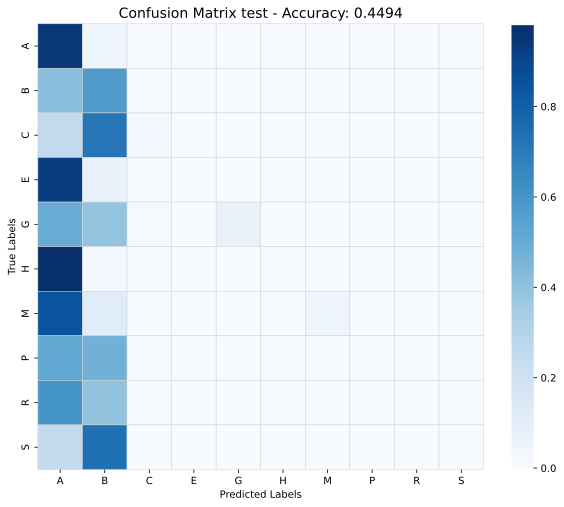

In [15]:
from tqdm import tqdm

iou = 0.0
horizon_correct = 0
horizon_topk_correct = 0
label_embeddings_tensor = torch.tensor(dataprocessor.embeddings_dict['embedding'], device=device).float()
hor_topk = 5
hor_topk_acc = lambda k : TopKHorizonAccuracy(label_embeddings_tensor, k=k)
hor_class_average = 'macro'
hor_possible_labels = list(range(label_embeddings_tensor.size(0)))
all_horizon_labels = []
all_topk_horizon_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        padded_images, image_mask, geotemp_features, padded_true_depths, padded_segments_tabulars_labels, padded_true_horizon_indices = batch
        padded_images, image_mask, geotemp_features, padded_true_depths, padded_segments_tabulars_labels, padded_true_horizon_indices = (
            padded_images.to(device),
            image_mask.to(device),
            geotemp_features.to(device),
            padded_true_depths.to(device),
            padded_segments_tabulars_labels.to(device),
            padded_true_horizon_indices.to(device)
        )
        
        ### TASK 1: Predict depth markers based on concatenated vector
        pred_depth_markers = depth_predictor(padded_images, image_mask, geotemp_features[:, 1:]) # 'index' column not used in model
        
        ### TASK 2: Predict tabular features for each segment
        # Crop image to segments
        segments = extract_segments(padded_images, image_mask, pred_depth_markers,
                                    segments_random_patches=tabular_predictor.predefined_random_patches, # True, use ResNet segment encoder
                                    patch_cnn_segment_size=None, # not needed for ResNet segment encoder
                                    
                                    num_patches_per_segment=48,
                                    segment_random_patch_size=224, 
                                    # Note: these two attributes are available in SegmentPatchesTabularDataset when training the simple tabular, 
                                    # bot not in ImageTabularEnd2EndDataset when training SoilNet (there, they are attributes of the model itself)
                                    
                                    stop_token=depth_predictor.stop_token,
                                    max_seq_len=depth_predictor.depth_marker_predictor.max_seq_len)
        
        tabular_predictions = tabular_predictor(segments, geotemp_features[:, 1:]) # 'index' column not used in model
        
        ### TASK 3: Compute horizon embedding from the final concatenated vector
        # Concatenate tabular features from dictionary
        processed_tabular_features = torch.cat([tabular_predictions[key] for key in tabular_predictor.tabular_predictors.keys()], dim=-1)

        padded_pred_horizon_embeddings = horizon_resnet_emb_predictor(segments, processed_tabular_features, geotemp_features[:, 1:]) 
        pred_horizon_embeddings   = torch.stack([pred for pred, lab in zip(padded_pred_horizon_embeddings.view(-1, padded_pred_horizon_embeddings.size(-1)), padded_true_horizon_indices.view(-1)) if lab != -1]).to(device)
        pred_topk_horizon_indices = torch.topk(torch.matmul(pred_horizon_embeddings, label_embeddings_tensor.T), k=hor_topk, dim=1).indices
        
        # Normalize pred. embeddings for the cosine loss, true embeddings are already normalized
        pred_horizon_embeddings = F.normalize(pred_horizon_embeddings, p=2, dim=1)

        ### Compute metrics
        # Update depth IoU separately
        iou += depth_iou(pred_depth_markers, padded_true_depths, depth_predictor.stop_token)
        
        ## True horizons
        true_horizon_embeddings = torch.stack([torch.tensor(dataprocessor.embeddings_dict['embedding'][lab.item()]) for lab in padded_true_horizon_indices.view(-1) if lab != -1]).to(device)
        true_horizon_indices = padded_true_horizon_indices.view(-1)[padded_true_horizon_indices.view(-1) != -1]
        
        horizon_correct      += hor_topk_acc(1)(pred_horizon_embeddings, true_horizon_indices)
        horizon_topk_correct += hor_topk_acc(hor_topk)(pred_horizon_embeddings, true_horizon_indices)
        
        all_topk_horizon_predictions.append(pred_topk_horizon_indices.cpu())
        all_horizon_labels.append(true_horizon_indices.cpu())

# Average IoU and horizon accuracies
iou /= len(test_loader)
eval_horizon_acc      = horizon_correct / len(test_loader)
eval_horizon_topk_acc = horizon_topk_correct / len(test_loader)

all_horizon_labels = torch.cat(all_horizon_labels).numpy()

top1_horizon_predictions = torch.cat(all_topk_horizon_predictions)[:, 0]
topk_horizon_predictions = torch.cat(all_topk_horizon_predictions)

precision_at_k, recall_at_k = precision_recall_at_k(all_horizon_labels, topk_horizon_predictions.numpy(), 
                                                    all_labels=hor_possible_labels, average=hor_class_average)
prec = precision_score(all_horizon_labels, top1_horizon_predictions.numpy(), 
                    labels=hor_possible_labels, average=hor_class_average, zero_division=0)
rec  = recall_score(all_horizon_labels, top1_horizon_predictions.numpy(), 
                    labels=hor_possible_labels, average=hor_class_average, zero_division=0)
f1   = f1_score(all_horizon_labels, top1_horizon_predictions.numpy(), 
                labels=hor_possible_labels, average=hor_class_average, zero_division=0)

terminal_plot, main_plot = plot_confusion_matrices(all_horizon_labels, top1_horizon_predictions.numpy(), dataprocessor.embeddings_dict, "notebook_output/horizon_embeddings") 

In [ ]:
# Check metrics
print(f"Depth IoU: {iou:.4f}")
print(f"Horizon accuracy: {eval_horizon_acc:.4f}")
print(f"Horizon top-{hor_topk} accuracy: {eval_horizon_topk_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision at {hor_topk}: {precision_at_k:.4f}")
print(f"Recall at {hor_topk}: {recall_at_k:.4f}")
print(f"F1 score: {f1:.4f}")

Depth IoU: 0.5174
Horizon accuracy: 0.2630
Horizon top-5 accuracy: 0.3370
Precision: 0.0147
Recall: 0.0149
Precision at 5: 0.1569
Recall at 5: 0.1028
F1 score: 0.0085


#### Horizon, cross entropy, ResNet segment encoder

Evaluating: 100%|██████████| 83/83 [00:49<00:00,  1.68it/s]


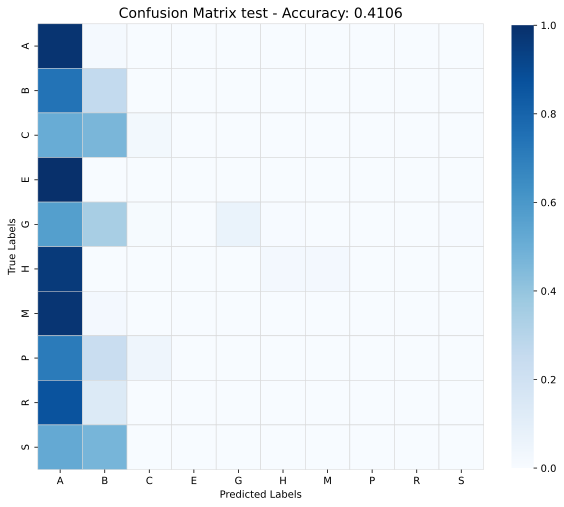

In [17]:
from tqdm import tqdm

iou = 0.0
horizon_correct = 0
horizon_topk_correct = 0
label_embeddings_tensor = torch.tensor(dataprocessor.embeddings_dict['embedding'], device=device).float()
hor_topk = 5
hor_class_average = 'macro'
hor_possible_labels = list(range(label_embeddings_tensor.size(0)))
all_horizon_labels = []
all_topk_horizon_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        padded_images, image_mask, geotemp_features, padded_true_depths, padded_segments_tabulars_labels, padded_true_horizon_indices = batch
        padded_images, image_mask, geotemp_features, padded_true_depths, padded_segments_tabulars_labels, padded_true_horizon_indices = (
            padded_images.to(device),
            image_mask.to(device),
            geotemp_features.to(device),
            padded_true_depths.to(device),
            padded_segments_tabulars_labels.to(device),
            padded_true_horizon_indices.to(device)
        )
        
        # Mask for valid indices
        mask = padded_true_horizon_indices != -1
        
        ### TASK 1: Predict depth markers based on concatenated vector
        pred_depth_markers = depth_predictor(padded_images, image_mask, geotemp_features[:, 1:]) # 'index' column not used in model
        
        ### TASK 2: Predict tabular features for each segment
        # Crop image to segments
        segments = extract_segments(padded_images, image_mask, pred_depth_markers,
                                    segments_random_patches=tabular_predictor.predefined_random_patches, # True, use ResNet segment encoder
                                    patch_cnn_segment_size=None, # not needed for ResNet segment encoder
                                    
                                    num_patches_per_segment=48,
                                    segment_random_patch_size=224, 
                                    # Note: these two attributes are available in SegmentPatchesTabularDataset when training the simple tabular, 
                                    # bot not in ImageTabularEnd2EndDataset when training SoilNet (there, they are attributes of the model itself)
                                    
                                    stop_token=depth_predictor.stop_token,
                                    max_seq_len=depth_predictor.depth_marker_predictor.max_seq_len)
        
        tabular_predictions = tabular_predictor(segments, geotemp_features[:, 1:]) # 'index' column not used in model
        
        ### TASK 3: Compute horizon embedding from the final concatenated vector
        # Concatenate tabular features from dictionary
        processed_tabular_features = torch.cat([tabular_predictions[key] for key in tabular_predictor.tabular_predictors.keys()], dim=-1)

        padded_pred_logits = horizon_resnet_ce_predictor(segments, processed_tabular_features, geotemp_features[:, 1:]) 
        pred_logits = padded_pred_logits.view(-1, padded_pred_logits.size(-1))[mask.view(-1)]  # Apply mask
        pred_topk_horizon_indices = torch.topk(padded_pred_logits.view(-1, padded_pred_logits.size(-1)), k=hor_topk, dim=1).indices[mask.view(-1)]  # Apply same mask

        ### Compute metrics
        # Update depth IoU separately
        iou += depth_iou(pred_depth_markers, padded_true_depths, depth_predictor.stop_token)
        
        ## True horizons
        true_horizon_indices = padded_true_horizon_indices.view(-1)[padded_true_horizon_indices.view(-1) != -1]
        
        horizon_correct      += top_k_accuracy(pred_logits, true_horizon_indices, 1)
        horizon_topk_correct += top_k_accuracy(pred_logits, true_horizon_indices, hor_topk)
        
        all_topk_horizon_predictions.append(pred_topk_horizon_indices.cpu())
        all_horizon_labels.append(true_horizon_indices.cpu())

# Average IoU and horizon accuracies
iou /= len(test_loader)
eval_horizon_acc      = horizon_correct / len(test_loader)
eval_horizon_topk_acc = horizon_topk_correct / len(test_loader)

all_horizon_labels = torch.cat(all_horizon_labels).numpy()

top1_horizon_predictions = torch.cat(all_topk_horizon_predictions)[:, 0]
topk_horizon_predictions = torch.cat(all_topk_horizon_predictions)

precision_at_k, recall_at_k = precision_recall_at_k(all_horizon_labels, topk_horizon_predictions.numpy(), 
                                                    all_labels=hor_possible_labels, average=hor_class_average)
prec = precision_score(all_horizon_labels, top1_horizon_predictions.numpy(), 
                    labels=hor_possible_labels, average=hor_class_average, zero_division=0)
rec  = recall_score(all_horizon_labels, top1_horizon_predictions.numpy(), 
                    labels=hor_possible_labels, average=hor_class_average, zero_division=0)
f1   = f1_score(all_horizon_labels, top1_horizon_predictions.numpy(), 
                labels=hor_possible_labels, average=hor_class_average, zero_division=0)

terminal_plot, main_plot = plot_confusion_matrices(all_horizon_labels, top1_horizon_predictions.numpy(), dataprocessor.embeddings_dict, "notebook_output/horizon_cross_entropy") 

In [ ]:
# Check metrics
print(f"Depth IoU: {iou:.4f}")
print(f"Horizon accuracy: {eval_horizon_acc:.4f}")
print(f"Horizon top-{hor_topk} accuracy: {eval_horizon_topk_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision at {hor_topk}: {precision_at_k:.4f}")
print(f"Recall at {hor_topk}: {recall_at_k:.4f}")
print(f"F1 score: {f1:.4f}")

Depth IoU: 0.5174
Horizon accuracy: 0.2525
Horizon top-5 accuracy: 0.4676
Precision: 0.0193
Recall: 0.0134
Precision at 5: 0.2335
Recall at 5: 0.0955
F1 score: 0.0081
